In [1]:
  # Import libraries
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scikitplot as skplt

from plotly.offline import iplot

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from tensorflow import keras
from tensorflow.keras import initializers, layers

## Load dataset relating items and skills

In [2]:
datas = list()
originals = list()
masks = list()

for i in range(100):
    data = pd.read_csv('output_data/25_missing/y/Y_rep' + str(i+1) + '_transformer_25_missing.csv', sep=';', header=None)
    data_train = np.ones(data.shape)
    data_train[data < 0.5] = 0.
    datas.append(data_train)
    original = pd.read_csv('input_data/y/Yrep' + str(i+1) + '.csv', sep=';', header=None)
    originals.append(original.values.reshape((180, 10000)).transpose()[:8000, :])
    masks.append(pd.read_csv('output_data/25_missing/masked/Masked_rep' + str(i+1) + '_25_missing.csv', sep=';', header=None))


In [3]:
Q = pd.read_csv('input_data/qmatrix/Qmatrix.csv', sep=';', header=None)
Q = Q.T
print(Q.shape)

(21, 180)


In [4]:
for d, m, o in zip(datas, masks, originals):

    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m.iloc[i, j] != -1 and d[i, j] != o[i, j]:
                d[i, j] = o[i, j]

In [5]:
print(datas)

[array([[0., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]]), array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[1., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]]), array([[0., 0., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[0., 0., 1., ..., 1., 1.

In [6]:
# Set stats and skills
num_stats = datas[0].shape[1] 
num_skills = 21

intermediate_dim=40

# Number of subjects
N = datas[0].shape[0]
# Training number
tr = N
batch_size = 50
epochs = 100

In [7]:
""" Helper functions """

# Restrict connection in decoder
def q_constraint(w):
    target = w * Q
    diff = w - target
    w = w * tf.cast(tf.math.equal(diff, 0), keras.backend.floatx()) 
    return w * tf.cast(tf.math.greater_equal(w, 0), keras.backend.floatx())

# Remove zeros function
def remove_zeros(arr):
  n_arr = []
  
  for j in range(num_skills): 
    for i in range(num_stats):
      if Q.iloc[j, i] != 0:
        n_arr.append(arr[j][i])
  
  return n_arr


In [8]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(keras.Model):
    """Maps items respone to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=num_skills, intermediate_dim=intermediate_dim, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="tanh")
        self.dense_mean = layers.Dense(latent_dim
                                       #, kernel_initializer=initializers.Zeros()
                                       )
        self.dense_log_var = layers.Dense(latent_dim
                                          #, kernel_initializer=initializers.Zeros()
                                          )
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        #tf.print(tf.math.reduce_mean(z_mean))
        z_log_var = self.dense_log_var(x)
        #tf.print(tf.math.reduce_mean(tf.math.exp(0.5 * z_log_var)))

        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(keras.Model):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim=num_skills, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        #self.dense_proj = layers.Dense(latent_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim
                                         , activation="sigmoid"
                                         , kernel_constraint=q_constraint
                                         #, kernel_initializer=initializers.Ones()
                                         #, bias_initializer=initializers.Zeros()
                                         )

    def call(self, inputs):
        #x = self.dense_proj(inputs)
        return self.dense_output(inputs)



class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=intermediate_dim,
        latent_dim=num_skills,
        name="autoencoder"
    ):
        super(VariationalAutoEncoder, self).__init__(name=name)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim)

    def call(self, inputs):
        self.z_mean, self.z_log_var, self.z = self.encoder(inputs)
        reconstructed = self.decoder(self.z)
        return reconstructed

    # Loss function
    def vae_loss(self, input, output):
        cross_entropy_loss = (num_stats / 1.0) * keras.losses.binary_crossentropy(input, output)
        kl_loss = -0.5 * tf.reduce_mean(self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var) + 1, axis=-1)
        return cross_entropy_loss + kl_loss

    # Get weights
    def _get_weights(self):
        return self.decoder.trainable_weights

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

In [9]:
thetas = pd.DataFrame()
thetas_logvar = pd.DataFrame()
discrs_hat = pd.DataFrame()
diffs = pd.DataFrame()
preds = pd.DataFrame()

for i in range(100):
    
    vae_q = VariationalAutoEncoder(num_stats, intermediate_dim, num_skills)

    # Optimizer
    #opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    opt = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    vae_q.compile(optimizer=opt, loss=vae_q.vae_loss, metrics=['binary_accuracy'])

    data_train = datas[i]
    
    history = vae_q.fit(data_train,
                        data_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True)
    # validation_split=0.2
    ba = 0
    for value in history.history['binary_accuracy']:
        ba += value
    print("Binary Accuracy: %.4f" % (ba / epochs))

    encoder = vae_q.get_encoder()
    decoder = vae_q.get_decoder()
    #weights = vae_q.get_decoder().trainable_weights

    weights = vae_q._get_weights()

    discr = weights[0].numpy()
    #print(discr.shape)
    #diff = pd.DataFrame(weights[3].numpy())
    negative_diff = pd.DataFrame(np.negative(weights[1].numpy()))

    # Get latent trait predictions
    thetas_hat, log_var_thetas_hat, z_pred = encoder.predict(data_train)
    pred = decoder.predict_step(z_pred)
    #print(pred)
    #print(thetas_hat)

    # Total score on the test -------
    score = np.apply_over_axes(np.sum, data_train, 1)

    #### Vectoring the matrices Thetas_hat ans discr ####
    theta_hat = np.transpose(thetas_hat).flatten()
    #step_theta_hat = np.transpose(step_thetas_hat.numpy()).flatten()
  
    log_var_theta_hat = np.transpose(log_var_thetas_hat).flatten()
    #step_log_var_theta_hat = np.transpose(step_log_var_thetas_hat.numpy()).flatten()

    discr_hat = remove_zeros(discr)

    # Save results
    theta_est_rep_GUI = pd.DataFrame({'Thetas Estimation': theta_hat, 'Log Var Thetas Estimation': log_var_theta_hat})
    theta_est_rep_GUI.to_csv('output_data/25_missing/theta/thetas_rep' + str(i+1) + '_transformer_25_missing.csv', sep=';', index=False)
    thetas['Rep' + str(i+1)] = theta_hat
    thetas_logvar['Rep' + str(i+1)] = log_var_theta_hat

    discr = pd.DataFrame(discr)
    discr.to_csv('output_data/25_missing/a/discr_rep' + str(i+1) + '_transformer_25_missing.csv', sep=';', header=None, index=False)

    discr_hat_GUI = pd.DataFrame([discr_hat])
    discr_hat_GUI.to_csv('output_data/25_missing/a/discr_hat_rep' + str(i+1) + '_transformer_25_missing.csv', sep=';', header=None, index=False)
    discrs_hat['Rep' + str(i+1)] = discr_hat

    # Save a estimated replication TRANSPOSED
    discr_hat_GUI.T.to_csv(
        'output_data/25_missing/a/discr_hat_rep' + str(i+1) + '_transformer_25_missing_TRANSPOSED.csv', sep=';', header=None, index=False)

    negative_diff.to_csv('output_data/25_missing/b/diff_rep' + str(i+1) + '_transformer_25_missing.csv', sep=';', header=None, index=False)
    diffs['Rep' + str(i+1)] = np.negative(weights[1].numpy())

    preds['Rep' + str(i+1)] = pred.numpy().flatten()


Epoch 1/100


2023-07-25 14:11:40.440342: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


160/160 [==============================] - 1s 797us/step - loss: 122.6595 - binary_accuracy: 0.6105
Epoch 2/100
160/160 [==============================] - 0s 886us/step - loss: 117.9424 - binary_accuracy: 0.6454
Epoch 3/100
160/160 [==============================] - 0s 788us/step - loss: 113.7739 - binary_accuracy: 0.6650
Epoch 4/100
160/160 [==============================] - 0s 802us/step - loss: 110.4670 - binary_accuracy: 0.6766
Epoch 5/100
160/160 [==============================] - 0s 787us/step - loss: 107.7263 - binary_accuracy: 0.6889
Epoch 6/100
160/160 [==============================] - 0s 768us/step - loss: 105.1367 - binary_accuracy: 0.7009
Epoch 7/100
160/160 [==============================] - 0s 782us/step - loss: 102.9272 - binary_accuracy: 0.7102
Epoch 8/100
160/160 [==============================] - 0s 783us/step - loss: 101.0736 - binary_accuracy: 0.7181
Epoch 9/100
160/160 [==============================] - 0s 763us/step - loss: 99.3852 - binary_accuracy: 0.7255
Epoch

In [10]:
binary_preds = np.ones(preds.shape)
binary_preds[preds.values < 0.5] = 0.

In [11]:
binary_preds = pd.DataFrame(binary_preds, columns=preds.columns)

In [12]:
# a artificial
a_values = pd.read_csv('input_data/a/a_values.csv', sep=';', header=None)
#a_rep_gui = pd.read_csv('output/discr_hat_transformer_10_missing_TRANSPOSED.csv', sep=';', header=0)

# b artificial
b_values = pd.read_csv('input_data/b/b_values.csv', sep=';', header=None)
#b_rep_gui = pd.read_csv('output/diff_transformer_10_missing.csv', sep=';', header=0)

# theta artificial
theta_values = pd.read_csv('input_data/theta/theta_values.csv', sep=';', header=None)
#theta_rep_gui = pd.read_csv('output/thetas_transformer_10_missing.csv', sep=';', header=0)

## Discriminations

In [13]:
cols = ['a_values']

a_results = pd.DataFrame(columns=cols)

a_results['a_values'] = a_values

a_results = pd.concat([a_results, discrs_hat], axis=1)

In [14]:
a_results['Bias'] = np.sum(a_values.values - discrs_hat.values, axis=1)/100
a_results['RMSE'] = np.sqrt(np.sum((a_values.values - discrs_hat)**2, axis=1)/100)
a_results['Abs Bias'] = np.sum(np.abs(a_values.values - discrs_hat.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/1112998409.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/1112998409.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/1112998409.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [15]:
corrs = []

for column in discrs_hat:
    corrs.append(a_results['a_values'].corr(discrs_hat['Rep1']))

a_results['Corr'] = ""
a_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/741033095.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/741033095.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
a_results

,a_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,1.164934,0.729248,0.786206,0.777077,0.731016,0.726733,0.722769,0.774534,0.766823,0.744748,...,0.738566,0.752168,0.767061,0.747719,0.745602,0.738543,0.418031,0.418546,0.418031,0.819847
1,0.761002,0.516643,0.502121,0.501359,0.534041,0.538904,0.510210,0.525733,0.528270,0.516980,...,0.552319,0.510557,0.499474,0.560403,0.565001,0.543186,0.235745,0.236526,0.235745,
2,0.823079,0.492712,0.515109,0.471291,0.498607,0.509940,0.500871,0.518939,0.506613,0.482920,...,0.477407,0.507154,0.489444,0.502702,0.537055,0.523902,0.313963,0.314930,0.313963,
3,1.507663,0.931617,0.939127,0.961178,0.935679,0.927571,0.946853,0.903276,0.956695,0.961075,...,0.965479,0.938524,0.939839,0.896755,0.921407,0.908489,0.572285,0.572838,0.572285,
4,0.733496,0.520283,0.509862,0.532248,0.530844,0.506016,0.507677,0.535762,0.509071,0.537610,...,0.537642,0.468208,0.502641,0.525098,0.523162,0.540663,0.213858,0.214925,0.213858,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.819945,0.787317,0.819545,0.670177,0.744521,0.734764,0.681199,0.782495,0.712687,0.736726,...,0.719200,0.770702,0.694227,0.712712,0.707952,0.725396,0.084236,0.110615,0.084487,
296,1.348967,1.075784,1.056025,1.059549,1.053988,1.079424,1.001269,0.979355,1.006999,0.983310,...,1.091821,1.066150,0.972357,1.026122,0.948552,0.999770,0.298734,0.318706,0.298734,
297,0.774595,0.514637,0.499593,0.566230,0.604338,0.564683,0.500941,0.467421,0.391893,0.356849,...,0.544734,0.492175,0.469100,0.514291,0.560776,0.614997,0.253262,0.264251,0.253262,
298,1.662084,1.045461,1.085835,1.042740,1.101088,0.954910,1.034235,0.981602,0.949595,0.807513,...,1.120729,0.943155,0.973311,0.996588,1.136764,1.035031,0.629456,0.639109,0.629456,


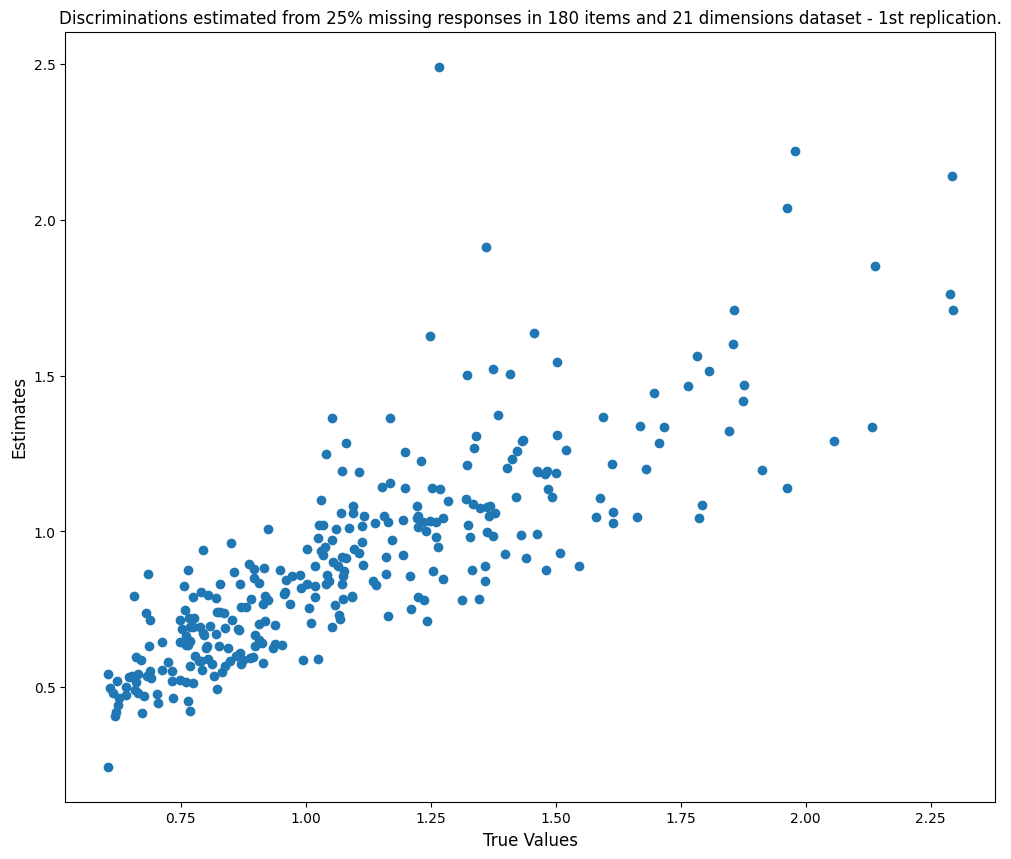

In [17]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=a_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Discriminations estimated from 25% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [18]:
a_results.to_csv('output_data/25_missing/a/a_results.csv', sep=';', header=True, index=False)

## Difficulties

In [19]:
cols = ['b_values']

b_results = pd.DataFrame(columns=cols)

b_results['b_values'] = b_values

b_results = pd.concat([b_results, diffs], axis=1)

In [20]:
b_results['Bias'] = np.sum(b_values.values - diffs.values, axis=1)/100
b_results['RMSE'] = np.sqrt(np.sum((b_values.values - diffs)**2, axis=1)/100)
b_results['Abs Bias'] = np.sum(np.abs(b_values.values - diffs.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/3793169349.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/3793169349.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/3793169349.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [21]:
corrs = []

for column in diffs:
    corrs.append(b_results['b_values'].corr(diffs[column]))

b_results['Corr'] = ""
b_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/713609593.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/713609593.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
b_results

,b_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-0.516250,-0.707006,-0.781918,-0.765965,-0.630718,-0.754611,-0.544551,-0.555642,-0.760198,-0.605136,...,-0.603543,-0.805746,-0.610612,-0.589528,-0.698416,-0.573847,0.138252,0.164832,0.138808,0.969591
1,-0.403987,-0.562448,-0.568489,-0.535026,-0.442956,-0.637318,-0.431699,-0.489629,-0.605652,-0.503999,...,-0.468741,-0.630954,-0.508287,-0.530127,-0.566787,-0.461820,0.112163,0.131122,0.112441,
2,-1.797941,-2.426018,-1.794318,-1.740197,-2.410480,-2.287668,-2.539320,-1.790540,-1.924188,-1.829260,...,-2.254608,-1.896275,-1.867886,-2.012690,-1.831355,-1.870285,0.248819,0.368049,0.269571,
3,0.763532,0.666801,1.542348,1.604454,0.707289,0.639992,0.631230,1.479321,1.356392,1.389736,...,0.675225,1.587788,1.535789,1.378602,1.577514,1.314238,-0.411817,0.595117,0.497386,
4,-0.787187,-0.956474,-0.976715,-0.936390,-0.958973,-1.005428,-0.856795,-0.838190,-1.067234,-0.910636,...,-0.799181,-0.898980,-0.885688,-0.975473,-1.063868,-0.909274,0.179970,0.202265,0.180291,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.660764,0.434926,0.326991,0.171839,0.330840,0.103975,0.456719,0.186689,0.311264,0.195566,...,0.401537,0.540076,0.393430,0.178602,0.058451,0.305332,0.352139,0.379090,0.352139,
176,0.928390,0.730412,0.750614,0.599409,0.623909,0.575497,0.726687,0.610000,0.653367,0.544057,...,0.744733,0.762691,0.614269,0.596176,0.565311,0.660164,0.262843,0.274753,0.263405,
177,-2.073206,-2.432544,-2.386917,-2.380415,-2.445943,-2.424450,-2.406227,-2.411274,-2.341106,-2.359982,...,-2.386692,-2.380554,-2.381997,-2.378941,-2.359829,-2.370799,0.317320,0.319905,0.317320,
178,0.197686,0.248226,0.236090,0.251318,0.238805,0.300921,0.304558,0.279491,0.271403,0.301566,...,0.306538,0.280927,0.271710,0.259725,0.289548,0.280313,-0.081030,0.084651,0.081030,


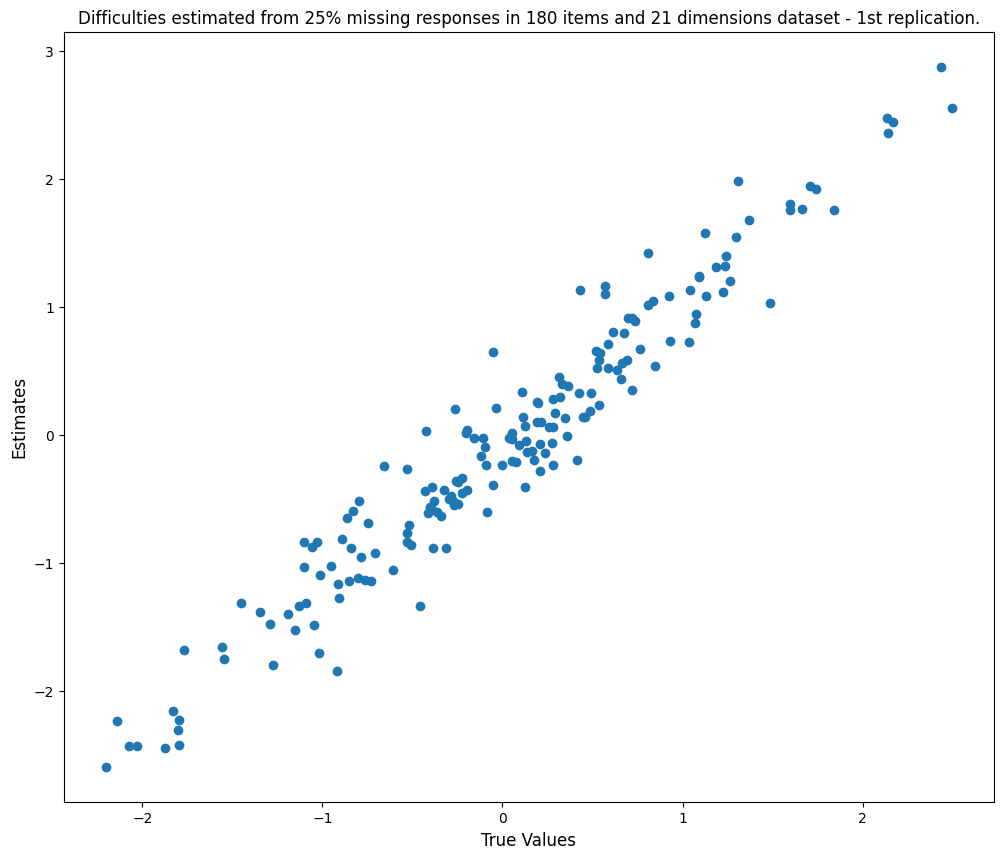

In [23]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values, y=b_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Difficulties estimated from 25% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [24]:
b_results.to_csv('output_data/25_missing/b/b_results.csv', sep=';', header=True, index=False)

## Thetas

In [25]:
theta_values = theta_values.values.reshape((21, 10000))[:, :8000].flatten()

In [26]:
cols = ['theta_values']

theta_results = pd.DataFrame(columns=cols)

theta_results['theta_values'] = theta_values

theta_results = pd.concat([theta_results, thetas], axis=1)


In [27]:
theta_values = theta_values.reshape((theta_values.shape[0], 1))

In [28]:
theta_results['Bias'] = np.sum(theta_values - thetas.values, axis=1)/100
theta_results['RMSE'] = np.sqrt(np.sum((theta_values - thetas)**2, axis=1)/100)
theta_results['Abs Bias'] = np.sum(np.abs(theta_values - thetas.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/3674056909.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/3674056909.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/3674056909.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [29]:
corrs = []

for column in thetas:
    corrs.append(theta_results['theta_values'].corr(thetas[column]))

theta_results['Corr'] = ""
theta_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/2499224961.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_40167/2499224961.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
theta_results

,theta_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-1.255686,-3.113315,-1.207021,-2.820211,-1.841283,-1.655374,-2.131022,-2.178099,-3.466546,-2.191846,...,-2.598693,-2.328846,-3.058787,-2.204589,-2.666774,-1.493245,1.061230,1.276219,1.097077,0.758912
1,0.417691,-0.031663,1.315436,1.016126,0.449836,1.126145,0.627576,1.297960,-0.648456,1.939700,...,-1.102248,0.747405,-0.135921,2.585665,-0.764409,1.757519,-0.176330,0.803148,0.627923,
2,-0.218857,-0.425635,-1.468808,-2.388878,-0.300193,-0.264677,0.420376,1.000125,-0.225271,-0.538976,...,-0.341414,-1.179041,-0.523605,-0.625644,-0.282240,-1.175716,0.187310,0.742063,0.577567,
3,0.506261,1.014109,0.387550,0.517192,1.369142,2.420529,2.102052,2.003785,1.375387,2.045567,...,0.060884,0.879158,1.615080,0.566235,0.605784,1.641092,-0.522863,0.841670,0.682421,
4,0.165964,-0.221308,0.588234,-0.848585,0.713807,0.428053,0.460757,-0.493943,1.290030,1.276203,...,0.725250,0.683422,0.798122,0.514333,-0.096806,-0.770105,0.050221,0.846192,0.664537,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,-1.058072,-2.537888,-0.494008,-0.241041,-0.155057,-2.029745,-0.563869,-1.111646,-2.677056,-0.661685,...,-1.121248,-1.830760,-2.182739,-0.071391,-2.324174,-1.369670,0.192198,0.869734,0.698476,
167996,-0.292246,0.484307,-0.616386,1.369075,0.115191,0.427734,0.607718,0.131151,-0.454479,-0.059615,...,-1.563207,-1.729814,0.554792,-2.168346,-0.454499,-0.373689,0.312167,0.943731,0.767313,
167997,-1.132776,-2.259553,-1.861593,-2.170114,-1.172307,-1.633559,-2.377603,-0.177003,-2.018623,-2.520796,...,-2.407065,-2.029919,-2.392779,-1.343353,-2.534042,-2.241244,0.577129,0.922819,0.805599,
167998,0.537725,-0.799299,0.904090,0.960101,0.011182,1.178504,1.079940,1.510709,3.112928,1.624444,...,-0.592661,0.776484,0.508721,0.368479,1.766216,1.165549,-0.018894,0.938642,0.765444,


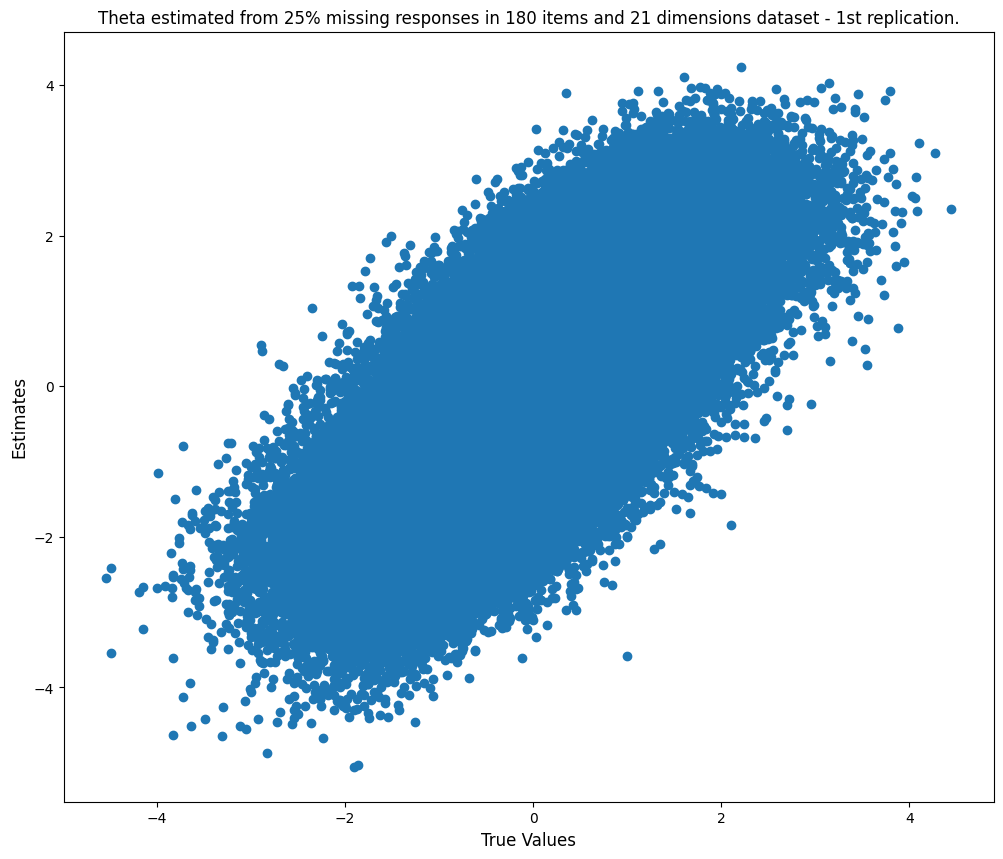

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Theta estimated from 25% missing responses in 180 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [32]:
theta_results.to_csv('output_data/25_missing/theta/theta_results.csv', sep=';', header=True, index=False)

In [ ]:
theta_df = pd.DataFrame()
theta_df['Estimate'] = thetas['Rep1']
theta_df['Dim'] = ""
theta_df['Dim'][:8000] = 1
theta_df['Dim'][8000:16000] = 2
theta_df['Dim'][16000:] = 3


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_df['Estimate'], c=theta_df['Dim'], cmap=plt.cm.Set1)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

## Confusion Matrix

In [ ]:
def matrix_metrix(real_values,pred_values):
   CM = confusion_matrix(real_values,pred_values)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   Recall     = round( TP / (TP+FN),4 )
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) 

   return {'CM': CM, 
           'TN': TN,
           'FN': FN,
           'TP': TP,
           'FP': FP,
           'Population': Population,
           'Accuracy': Accuracy,
           'Precision': Precision,
           'NPV': NPV,
           'FDR': FDR,
           'FOR': FOR,
           'Recall': Recall,
           'FPR': FPR,
           'FNR': FNR,
           'TNR': TNR
           }

In [ ]:
print(confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1']))
skplt.metrics.plot_confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1'],figsize=(8,8))

In [ ]:
res = matrix_metrix(np.array(originals[0]).flatten(), binary_preds['Rep1'])

df = pd.DataFrame({'Metric': res.keys(), 'Value': res.values()})

print(df)

In [ ]:
fpr, tpr, thresholds = roc_curve(np.array(originals[0]).flatten(), preds['Rep1'])
auc = roc_auc_score(np.array(originals[0]).flatten(), preds['Rep1'])
print('AUC: %.3f' % auc)

plt.plot(fpr, tpr, linestyle='--', label='Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(np.array(originals[0]).flatten(), preds['Rep1'])

plt.plot(recall, precision, linestyle='--', label='Precision versus Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Charts

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=thetas[0]['Thetas Estimation'])
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
print(b_values.shape)
print(negative_diff.shape)

In [ ]:


fig_a = go.Figure()
fig_a.add_trace(go.Scatter(y=discr_hat, mode='lines', name='Python'))
fig_a.add_trace(go.Scatter(y=a_values.iloc[:,0], mode='lines', name='a Real'))
fig_a.update_layout( title="Discrimation")
fig_a.show()

fig_b = go.Figure()
fig_b.add_trace(go.Scatter(y=negative_diff.iloc[:,0], mode='lines', name='Python'))
fig_b.add_trace(go.Scatter(y=b_values.iloc[:,0], mode='lines', name='b Real'))
fig_b.update_layout(title="Difficulty")
fig_b.show()

fig_theta = go.Figure()
#fig_theta.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], mode='lines', name='Python'))
fig_theta.add_trace(go.Scatter(y=theta_values.iloc[:,0], mode='lines', name='Real'))
fig_theta.update_layout( title="Theta Real")
fig_theta.show()

fig_t = go.Figure()
fig_t.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], line=dict(color='green',), mode='lines', name='Python'))
#fig_t.add_trace(go.Scatter(y=theta_rep['Thetas_est'], line=dict(color='green',),mode='lines', name='R'))
fig_t.update_layout( title="Theta Hat Python")
fig_t.show()



In [ ]:
theta_values = theta_values.values.reshape((21, 10000)).transpose()

In [ ]:
print(theta_hat.shape)
print(theta_values[:N, :].flatten().shape)

In [ ]:
print(len(discr))

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values[:N, :].flatten(), y=thetas_hat)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
len(discr_hat)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=discr_hat)
#plt.colorbar()
plt.xlabel("True Values of a_values")
plt.ylabel("Estimates")
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values.values.flatten(), y=negative_diff)
#plt.colorbar()
plt.xlabel("True Values of b_values")
plt.ylabel("Estimates")
plt.show()